## Purchase Order Extraction using Document AI and Python

In this tutorial, we will use Document AI's specialized processor (Purchase Order Parser). For learning purpose, we use example cards available in Google search.

We will follow this [official documentation](https://cloud.google.com/document-ai/docs/processors-list#specialized_processors) as reference.

#### 1. Setup Environment

In [1]:
import os
import json
from google.cloud import documentai_v1 as documentai
from google.oauth2 import service_account
from mimetypes import guess_type
from dotenv import load_dotenv
import PIL.Image
import pandas as pd

In [2]:
load_dotenv()
project_id = os.environ['PROJECT_ID']
location = os.environ['REGION']
processor_id = os.environ['PO_PROCESSOR_ID']

In [3]:
service_account_path = '../norse.json' # change this path
credentials = service_account.Credentials.from_service_account_file(service_account_path)   

#### 2. Create Extraction Function

In [4]:
def online_process(
    project_id: str,
    location: str,
    processor_id: str,
    file_path: str,
    file_name: str,
) -> documentai.Document:
    """
    Processes a document using the Document AI Online Processing API.
    """

    opts = {"api_endpoint": f"{location}-documentai.googleapis.com"}

    # Instantiates a client by passing credentials and the API endpoint
    documentai_client = documentai.DocumentProcessorServiceClient(client_options=opts, credentials=credentials)

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    resource_name = documentai_client.processor_path(project_id, location, processor_id)

    # Read the file into memory
    with open(file_path, "rb") as file:
        file_content = file.read()

    # Guess the MIME type based on the file name
    mime_type, _ = guess_type(file_name)
    if mime_type is None:
        raise ValueError("Unable to determine the file's MIME type")

    # Load Binary Data into Document AI RawDocument Object
    raw_document = documentai.RawDocument(content=file_content, mime_type=mime_type)

    # Configure the process request
    request = documentai.ProcessRequest(name=resource_name, raw_document=raw_document)

    # Use the Document AI client to process the sample form
    result = documentai_client.process_document(request=request)

    entities = result.document.entities

    return entities

#### 3. Run The Extraction

##### Example A

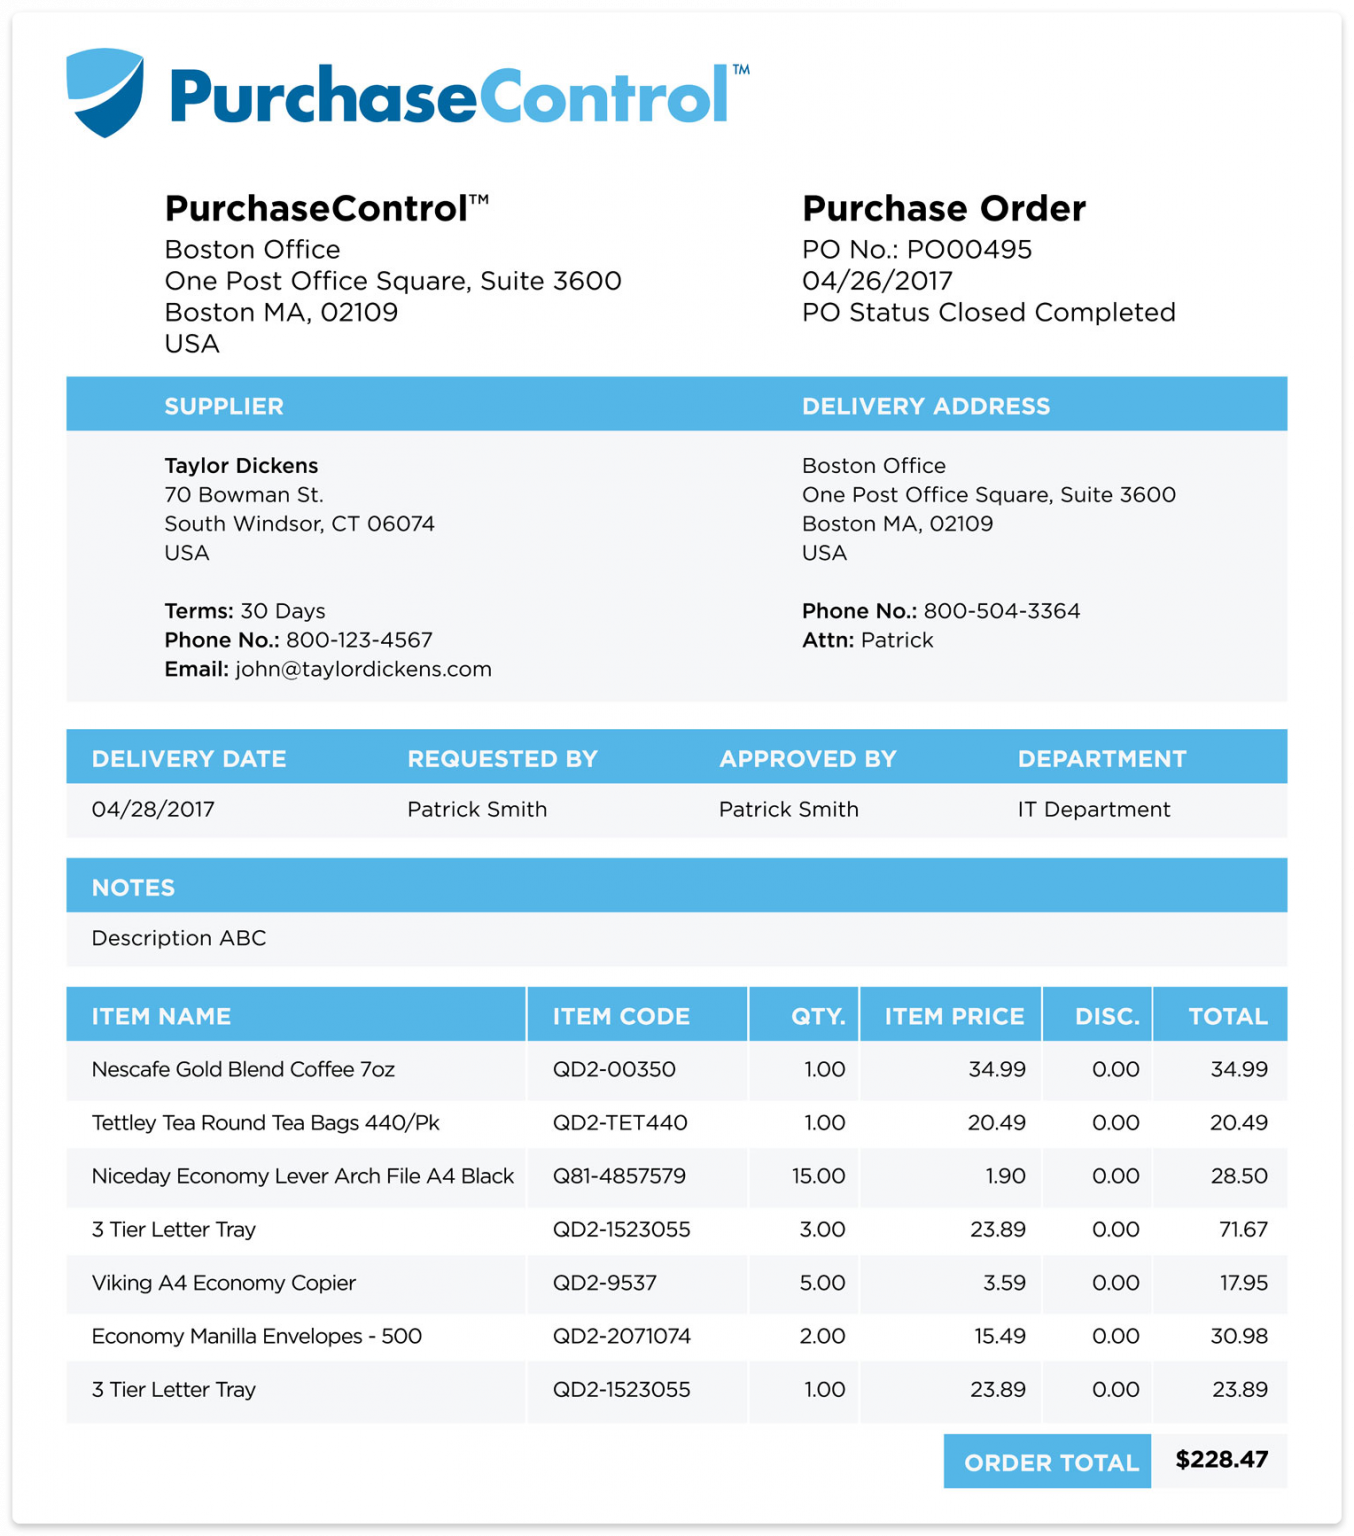

In [5]:
# load example id card
file_path = './examples/po1.png'
# Extract file name from file path
file_name = os.path.basename(file_path)

PIL.Image.open(file_path)

In [6]:
response = online_process(project_id, location, processor_id, file_path, file_name)

In [7]:
# Extract and display information from the document
types = []
raw_values = []
normalized_values = []
confidence = []

for entity in response:
    types.append(entity.type)
    raw_values.append(entity.mention_text)
    normalized_values.append(entity.normalized_value.text)
    confidence.append(f"{entity.confidence:.0%}")

    for prop in entity.properties:
        types.append(prop.type_)
        raw_values.append(prop.mention_text)
        normalized_values.append(prop.normalized_value.text)
        confidence.append(f"{prop.confidence:.0%}")

df = pd.DataFrame(
    {
        "Type": types,
        "Raw Value": raw_values,
        "Normalized Value": normalized_values,
        "Confidence": confidence,
    }
)
df

,Type,Raw Value,Normalized Value,Confidence
0,currency,$,USD,96%
1,purchase_order_id,PO00495,,94%
2,purchase_order_date,04/26/2017,2017-04-26,93%
3,total_amount,228.47,228.47,80%
4,ship_to_name,Boston Office,,73%
5,receiver_name,Boston Office,,69%
6,payment_terms,30 Days,,66%
7,delivery_date,04/28/2017,2017-04-28,35%
8,line_item,Nescafe Gold Blend Coffee 7oz QD2-00350 1.00 3...,,100%
9,line_item/description,Nescafe Gold Blend Coffee 7oz,,73%


##### Example B

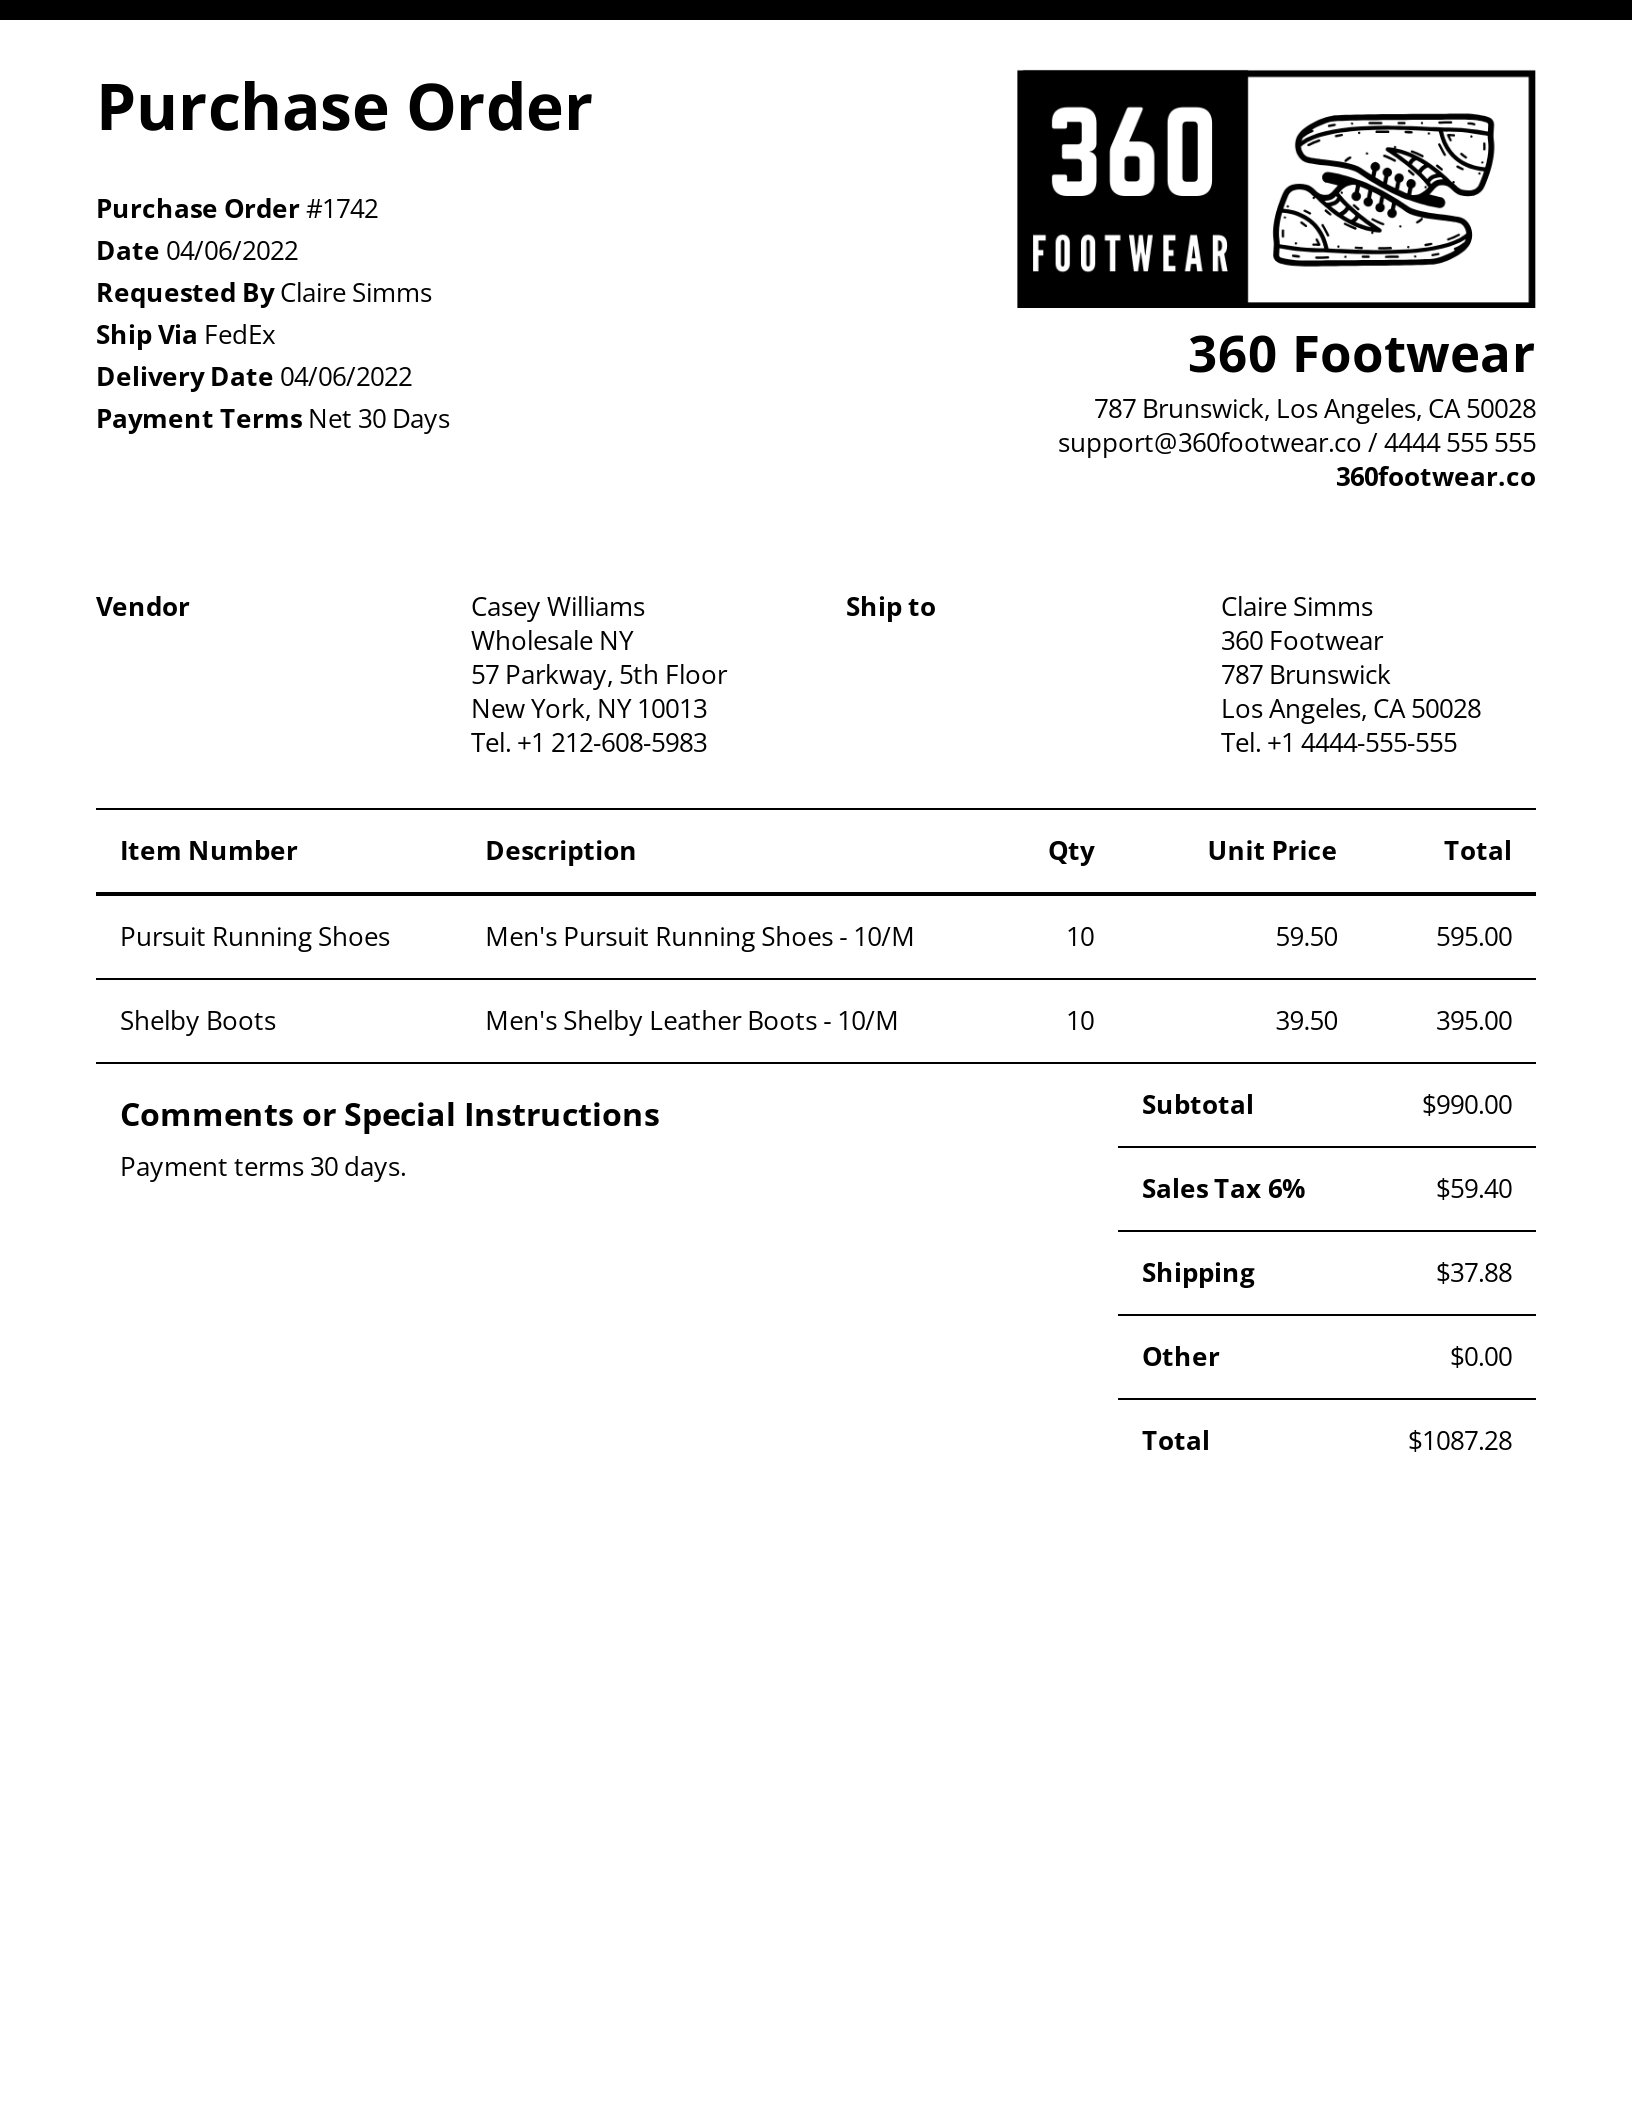

In [8]:
# load example id card
file_path = './examples/po2.png'
# Extract file name from file path
file_name = os.path.basename(file_path)

PIL.Image.open(file_path)

In [9]:
response = online_process(project_id, location, processor_id, file_path, file_name)

In [10]:
# Extract and display information from the document
types = []
raw_values = []
normalized_values = []
confidence = []

for entity in response:
    types.append(entity.type)
    raw_values.append(entity.mention_text)
    normalized_values.append(entity.normalized_value.text)
    confidence.append(f"{entity.confidence:.0%}")

    for prop in entity.properties:
        types.append(prop.type_)
        raw_values.append(prop.mention_text)
        normalized_values.append(prop.normalized_value.text)
        confidence.append(f"{prop.confidence:.0%}")

df = pd.DataFrame(
    {
        "Type": types,
        "Raw Value": raw_values,
        "Normalized Value": normalized_values,
        "Confidence": confidence,
    }
)
df

,Type,Raw Value,Normalized Value,Confidence
0,purchase_order_date,04/06/2022,2022-04-06,98%
1,currency,$,USD,93%
2,payment_terms,Net 30 Days,,91%
3,total_amount,1087.28,1087.28,87%
4,delivery_date,04/06/2022,2022-04-06,67%
5,purchase_order_id,#1742,,59%
6,ship_to_address,360 Footwear,,28%
7,line_item,Pursuit Running Shoes Men's Pursuit Running Sh...,,100%
8,line_item/description,Pursuit Running Shoes,,50%
9,line_item/description,Men's Pursuit Running Shoes - 10/M,,59%
